# Motive Basic Data Exploratory 
This notebook is to explore the data so that we can write up the data dictionary, additionally, draft up plan on how we should clean the data. The structure of this notebook will be. For each data set, we would go over the following steps: 
- Get the schema name
- Understanding null values
- Get Statistic Description for numerical values; I will ignore any id related columns if that column is integer data type 
- Determine outliers, if there is outlier, we create box plot to see the values range
- Categorical Values; get the unique values from the categorical. 
- At the end, we would write up some key observations about the data that need to be considered. 

For full description of the granularity of the data, please visit our data description pdf.

The tables that we are going to do data exploratory would be 
- `data_combined_events_w_vehicle_map.csv`
- `data_driving_periods_w_vehicle_map.csv`
- `data_inspections_w_vehicle_map.csv`
- `data_idle_events_w_vehicle_map.csv`
- `accident_register_combined_driverid.csv`
- `monthly_claims_insurance_driverid.csv` 

Some of the main observations that I have was: 
- Each table has vehicle related information like the model of the car, tha car's make, the status of that car etc
- For all 3 tables, the start date usually indicates the start time of the event or the start of the trips; The start date reflects when the company implements Motive. Therefore all 4 tables have date range from 2023 to March 10 2025 with a note that the data from 2023 contains loads of missing data due to slowly build rapport with vendor to use this tool
- there are missing driver_id for all 4 tables that need to drops
- `driving_distance` has less than values for table `data_driving_periods_w_vehicle_map.csv`, we need to drops value that less than 0 
- `minutes_idling` from table `data_idle_events_w_vehicle_map` has outliers that need to be taken care off as well 

For the accident related tables like `accident_register_combined_driverid` and `monthly_claims_insurance_driverid`: 
- Most of the accidents are recorded from 2023 to 2025
- There are a lot of drivers who doesn't have an assigned driver id, or drivers who doesn't have name associated with the accidents
- Not all accidents involve vehicle collisions—some result from work-related incidents that cause vehicle damage.
- Missing timestamps and location data in the accident register may introduce challenges when merging with external datasets like weather data.
- The accident dataset includes a Region field that indicates the FusionSite region where an accident occurred.


## System/Environment setup 


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

app_name = "final-proj"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

sc = spark.sparkContext

In [0]:
# import libraries
from pyspark.sql.functions import col, count, mean, stddev, min, max, when, isnan, countDistinct
import matplotlib.pyplot as plt
import seaborn as sns

## Data Exploratory 
For each table, in order to explore the data and understand what is the data about I am going to do the following 

### `data_combined_events_w_vehicle_map`

This is the data table that record whenever the driver doesn't comply or violate harard and safety events that are classified by Motive; some of the events are "seatbelt", "speeding" and "cellphones" 


In [0]:
combined_event_data = spark.read.csv('dbfs:/FileStore/tables/data_combined_events_w_vehicle_map.csv', inferSchema=True, header=True)
combined_event_data.show()

+-----+---------+-------------------+---------+-----------------+----------------+----------+---------------+-------------------+--------+-----+--------------------+--------------------+---------------------+---------------------+-----------+---------+-----------+--------------+--------------------+--------+--------------------+
|   id| event_id|               type|driver_id|driver_first_name|driver_last_name|vehicle_id|coaching_status|         start_date|severity|month|          created_at|          updated_at|max_over_speed_in_kph|max_over_speed_in_mph|not_current|   number|     status|          make|               model|group_id|          group_name|
+-----+---------+-------------------+---------+-----------------+----------------+----------+---------------+-------------------+--------+-----+--------------------+--------------------+---------------------+---------------------+-----------+---------+-----------+--------------+--------------------+--------+--------------------+
|60370|

In [0]:
from pyspark.sql.functions import col, count, when
# Show schema
print("Schema:")
combined_event_data.printSchema()
# Count missing values in each column
print("Missing Values:")
missing_values = combined_event_data.select([
    count(when(col(c).isNull(), c)).alias(c) for c in combined_event_data.columns
]).collect()[0]
for col_name, missing_count in zip(combined_event_data.columns, missing_values):
    print(f"{col_name}: {missing_count}")

Schema:
root
 |-- id: integer (nullable = true)
 |-- event_id: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- driver_id: double (nullable = true)
 |-- driver_first_name: string (nullable = true)
 |-- driver_last_name: string (nullable = true)
 |-- vehicle_id: integer (nullable = true)
 |-- coaching_status: string (nullable = true)
 |-- start_date: timestamp (nullable = true)
 |-- severity: string (nullable = true)
 |-- month: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- max_over_speed_in_kph: double (nullable = true)
 |-- max_over_speed_in_mph: double (nullable = true)
 |-- not_current: boolean (nullable = true)
 |-- number: string (nullable = true)
 |-- status: string (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- group_id: double (nullable = true)
 |-- group_name: string (nullable = true)

Missing Values:
id: 0
event_id: 0
type: 0
driver_id: 

In [0]:
# identify numerical and categorical columns
numerical_cols = [f.name for f in combined_event_data.schema.fields if f.dataType.simpleString() in ['int', 'double', 'float']]
categorical_cols = [f.name for f in combined_event_data.schema.fields if f.dataType.simpleString() in ['string', 'boolean', 'timestamp']]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['id', 'event_id', 'driver_id', 'vehicle_id', 'max_over_speed_in_kph', 'max_over_speed_in_mph', 'group_id']
Categorical columns: ['type', 'driver_first_name', 'driver_last_name', 'coaching_status', 'start_date', 'severity', 'month', 'created_at', 'updated_at', 'not_current', 'number', 'status', 'make', 'model', 'group_name']


#### Understanding data values for both categorical and numerical

In [0]:
# Summary statistics for numerical columns
filtered_numerical_cols = [c for c in numerical_cols if "_id" not in c and c!= "id_x" and c!= "id_y" ]

if filtered_numerical_cols:
    print("Summary Statistics for Numerical Columns:")
    summary_stats = combined_event_data.select(
        [mean(col(c)).alias(f"{c}_mean") for c in filtered_numerical_cols] +
        [stddev(col(c)).alias(f"{c}_stddev") for c in filtered_numerical_cols] +
        [min(col(c)).alias(f"{c}_min") for c in filtered_numerical_cols] +
        [max(col(c)).alias(f"{c}_max") for c in filtered_numerical_cols]
    )
    summary_stats.show()


Summary Statistics for Numerical Columns:
+------------------+--------------------------+--------------------------+-----------------+----------------------------+----------------------------+------+-------------------------+-------------------------+------+-------------------------+-------------------------+
|           id_mean|max_over_speed_in_kph_mean|max_over_speed_in_mph_mean|        id_stddev|max_over_speed_in_kph_stddev|max_over_speed_in_mph_stddev|id_min|max_over_speed_in_kph_min|max_over_speed_in_mph_min|id_max|max_over_speed_in_kph_max|max_over_speed_in_mph_max|
+------------------+--------------------------+--------------------------+-----------------+----------------------------+----------------------------+------+-------------------------+-------------------------+------+-------------------------+-------------------------+
|223347.18858940204|        20.731903633346562|        12.882203692556189|128951.2972390319|           7.861492825083497|           4.884903658214957| 

In [0]:
# Detect outliers using IQR method for numerical columns
print("Outliers Detection:")
outlier_results = {}
for c in numerical_cols:
    q1, q3 = combined_event_data.approxQuantile(c, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers_count = combined_event_data.filter((col(c) < lower_bound) | (col(c) > upper_bound)).count()
    outlier_results[c] = outliers_count

for col_name, count in outlier_results.items():
    print(f"Column {col_name} has {count} outliers.")

Outliers Detection:
Column id has 0 outliers.
Column event_id has 10899 outliers.
Column driver_id has 10339 outliers.
Column vehicle_id has 88031 outliers.
Column max_over_speed_in_kph has 9420 outliers.
Column max_over_speed_in_mph has 9420 outliers.
Column group_id has 75744 outliers.


I will ignore the columns that related to any sort of `_id` and only focus on analyzing max_over_speed variables by creating a boxplot 

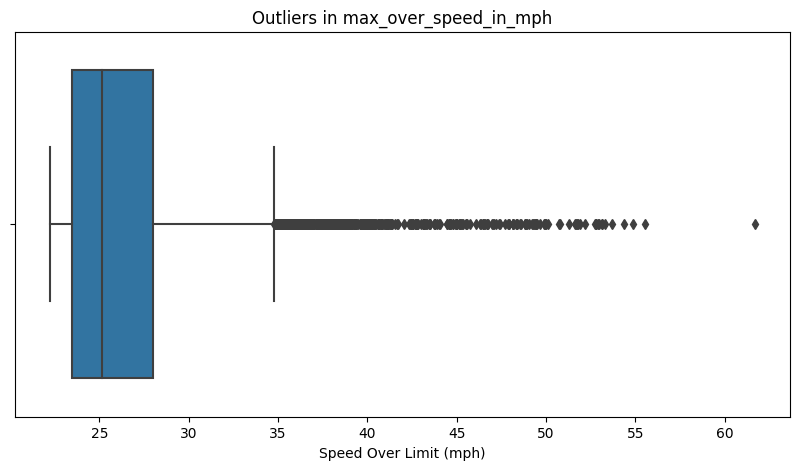

In [0]:
col_name = "max_over_speed_in_mph"
# IQR 
q1, q3 = combined_event_data.approxQuantile(col_name, [0.25, 0.75], 0.05)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# filter outliers
outliers_df = combined_event_data.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound)).toPandas()

# Plot outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=outliers_df[col_name])
plt.title(f"Outliers in {col_name}")
plt.xlabel("Speed Over Limit (mph)")
plt.show()

In [0]:
# Display unique value counts for categorical columns
print("Unique Value Counts for Categorical Columns:")
for c in categorical_cols:
    unique_count = combined_event_data.select(countDistinct(col(c))).collect()[0][0]
    print(f"{c}: {unique_count} unique values")

Unique Value Counts for Categorical Columns:
type: 16 unique values
driver_first_name: 698 unique values
driver_last_name: 1050 unique values
coaching_status: 4 unique values
start_date: 441772 unique values
severity: 4 unique values
month: 12 unique values
created_at: 834 unique values
updated_at: 698 unique values
not_current: 1 unique values
number: 1073 unique values
status: 2 unique values
make: 77 unique values
model: 323 unique values
group_name: 51 unique values


I am interested in seeing only some of the belows column as these columns will define what information would this table tells us 

In [0]:
# categorical columns of interest
categorical_columns = ["type","coaching_status", "severity", "group_name", "make", "status", "group_name"]

#  unique values for each specified categorical column
unique_values_dict = {}

for c in categorical_columns:
    unique_values = combined_event_data.select(col(c)).distinct().rdd.flatMap(lambda x: x).collect()
    unique_values_dict[c] = unique_values

for col_name, values in unique_values_dict.items():
    print(f"{col_name}: {values}")


type: ['cell_phone', 'ran_a_red_light', 'seat_belt_violation', 'camera_obstruction', 'distraction', 'tailgating', 'unsafe_lane_change', 'speeding', 'stop_sign_violation', 'crash', 'manual_event', 'driver_facing_cam_obstruction', 'near_miss', 'forward_collision_warning', 'road_facing_cam_obstruction', 'drowsiness']
coaching_status: ['uncoachable', 'coachable', 'pending_review', 'coached']
severity: ['critical', 'low', None, 'high', 'medium']
group_name: ['GA -PSI Augusta', 'NC - Denver', 'TN - Memphis - Safety Quip', 'TN - FusionSite (Nashville)', 'Goldthwaite', 'FL - Freedom', 'FL - JW Craft', None, 'FL - Gainsville Porta Serve', 'PA - Port A Bowl', 'GA - GCI', 'MS - Gotta Go', 'PA - Malvern', 'TN - FusionSite (Clark)', 'OH - Rent - A - John', 'NC - Griffin Hook trucks', 'KY - Lex', 'NC -  ASC', 'TN - MC Septic', 'TN - ETP ', 'TX - ACP', 'NY - A - John', 'NC - Griffin Waste Pump Trucks', 'SC - PSI Columbia', 'KY - Bullitt Sep. Service', 'KY - Moon Minis', 'OH - C&L and Safeway', 'AR - 

In [0]:
# get datetype range 
print("DateType Range: ")
datetime_cols = [f.name for f in combined_event_data.schema.fields if f.dataType.simpleString() == 'timestamp']
if datetime_cols:
    date_ranges = combined_event_data.select(
        [min(col(c)).alias(f"{c}_min") for c in datetime_cols] +
        [max(col(c)).alias(f"{c}_max") for c in datetime_cols]
    ).collect()[0]

    # prnt the date ranges in the desired format
    for i, col_name in enumerate(datetime_cols):
        min_date = date_ranges[i]
        max_date = date_ranges[i + len(datetime_cols)]
        print(f"{col_name}: ({min_date}, {max_date})")
else:
    print("No datetime columns found.")

DateType Range: 
start_date: (2023-01-01 00:56:22, 2025-02-27 23:50:57)
created_at: (2024-08-09 18:43:53.162886, 2025-02-28 09:20:29.457396)
updated_at: (2024-08-12 18:15:18.031315, 2025-02-28 09:20:29.457396)


**Observation**: 
- From the statistic table and this box plot,  I notice that overspeeding events are minor (average around 12.88 m/h over the limit  with median around 25 mph), but there are extreme cases where vehicles exceeded speed limits by nearly 55-60 mph.
- `max_over_speed_in_mph` and `max_over_speed_in_kph` can have null because this field only associate with speeding event
- `type` columns describe all the event that the Motive App tracks 
- `coaching_status` tells us given this hazard event, have the manager talk/ have a conversation with the driver yet
- `group_name` tells us about all the FusionSite site
- `make`: is the truck's make/model 
` `status`: tell us about the car status; if it is active, the vehicle is still in used;  None is when it couldn't find a matched vehicle with the database

 
## `data_driving_periods_w_vehicle_map`



In [0]:
driving_period = spark.read.csv('dbfs:/FileStore/tables/data_driving_periods_w_vehicle_map.csv', inferSchema=True, header=True)
driving_period.show()

+------+----------+---------+----------+-------------------+--------------------+----------------+-------------------+-----------------+------------------+-----+--------------------+--------------------+----------+-----------+-----+-------------+-----------+-----------+--------------------+--------+--------------------+
|  id_x|  event_id|driver_id|vehicle_id|         start_date|            end_date|driving_distance|driving_period_type|driver_company_id|   minutes_driving|month|          created_at|          updated_at|unassigned|not_current| id_y|       number|     status|       make|               model|group_id|          group_name|
+------+----------+---------+----------+-------------------+--------------------+----------------+-------------------+-----------------+------------------+-----+--------------------+--------------------+----------+-----------+-----+-------------+-----------+-----------+--------------------+--------+--------------------+
|586900|1873322883|3972537.0|   10

In [0]:
from pyspark.sql.functions import col, count, when
# Show schema
print("Schema:")
driving_period.printSchema()
# Count missing values in each column
print("Missing Values:")
missing_values = driving_period.select([
    count(when(col(c).isNull(), c)).alias(c) for c in driving_period.columns
]).collect()[0]
for col_name, missing_count in zip(driving_period.columns, missing_values):
    print(f"{col_name}: {missing_count}")

Schema:
root
 |-- id_x: integer (nullable = true)
 |-- event_id: long (nullable = true)
 |-- driver_id: double (nullable = true)
 |-- vehicle_id: integer (nullable = true)
 |-- start_date: timestamp (nullable = true)
 |-- end_date: string (nullable = true)
 |-- driving_distance: double (nullable = true)
 |-- driving_period_type: string (nullable = true)
 |-- driver_company_id: string (nullable = true)
 |-- minutes_driving: double (nullable = true)
 |-- month: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- unassigned: boolean (nullable = true)
 |-- not_current: string (nullable = true)
 |-- id_y: double (nullable = true)
 |-- number: string (nullable = true)
 |-- status: string (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- group_id: double (nullable = true)
 |-- group_name: string (nullable = true)

Missing Values:
id_x: 0
event_id: 0
driver_id: 791144
vehicle_id: 0

In [0]:
# identify numerical and categorical columns
numerical_cols = [f.name for f in driving_period.schema.fields if f.dataType.simpleString() in ['int', 'double', 'float']]
categorical_cols = [f.name for f in driving_period.schema.fields if f.dataType.simpleString() in ['string', 'boolean', 'timestamp']]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['id_x', 'driver_id', 'vehicle_id', 'driving_distance', 'minutes_driving', 'id_y', 'group_id']
Categorical columns: ['start_date', 'end_date', 'driving_period_type', 'driver_company_id', 'month', 'created_at', 'updated_at', 'unassigned', 'not_current', 'number', 'status', 'make', 'model', 'group_name']


### Understand Categorical and Numerical values

In [0]:
# Summary statistics for numerical columns
filtered_numerical_cols = [c for c in numerical_cols if "_id" not in c and c!= "id_x" and c!= "id_y"]
if filtered_numerical_cols:
    print("Summary Statistics for Numerical Columns:")
    summary_stats = driving_period.select(
        [mean(col(c)).alias(f"{c}_mean") for c in filtered_numerical_cols] +
        [stddev(col(c)).alias(f"{c}_stddev") for c in filtered_numerical_cols] +
        [min(col(c)).alias(f"{c}_min") for c in filtered_numerical_cols] +
        [max(col(c)).alias(f"{c}_max") for c in filtered_numerical_cols]
    )
    summary_stats.show()


Summary Statistics for Numerical Columns:
+---------------------+--------------------+-----------------------+----------------------+--------------------+-------------------+--------------------+-------------------+
|driving_distance_mean|minutes_driving_mean|driving_distance_stddev|minutes_driving_stddev|driving_distance_min|minutes_driving_min|driving_distance_max|minutes_driving_max|
+---------------------+--------------------+-----------------------+----------------------+--------------------+-------------------+--------------------+-------------------+
|    8.776980474373717|  20.505798066554817|      529.9734680918606|    213.46614829154302|           -272387.6| 0.0166666666666666|            284792.2| 199919.53333333333|
+---------------------+--------------------+-----------------------+----------------------+--------------------+-------------------+--------------------+-------------------+



In [0]:
# Detect outliers using IQR method for numerical columns
print("Outliers Detection:")
outlier_results = {}
for c in filtered_numerical_cols:
    q1, q3 = driving_period.approxQuantile(c, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers_count = driving_period.filter((col(c) < lower_bound) | (col(c) > upper_bound)).count()
    outlier_results[c] = outliers_count

for col_name, count in outlier_results.items():
    print(f"Column {col_name} has {count} outliers.")

Outliers Detection:
Column driving_distance has 362793 outliers.
Column minutes_driving has 264412 outliers.


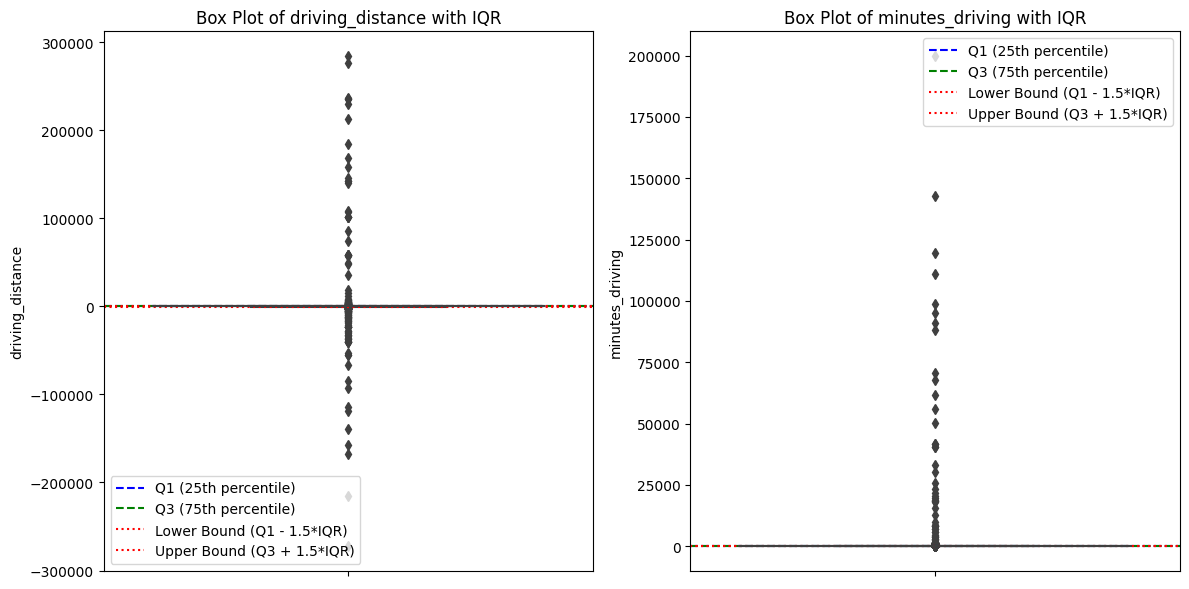

In [0]:
# visualizing outliers
columns_to_plot = ["driving_distance", "minutes_driving"]

# Convert to Pandas DataFrame
df = driving_period.select(columns_to_plot).toPandas()

# Create subplots for the box plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, col in enumerate(columns_to_plot):
    # Calculate Q1, Q3, and IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Plot boxplot
    sns.boxplot(y=df[col], ax=axes[i])
    
    #  IQR range
    axes[i].axhline(Q1, color='blue', linestyle='dashed', label="Q1 (25th percentile)")
    axes[i].axhline(Q3, color='green', linestyle='dashed', label="Q3 (75th percentile)")
    axes[i].axhline(Q1 - 1.5 * IQR, color='red', linestyle='dotted', label="Lower Bound (Q1 - 1.5*IQR)")
    axes[i].axhline(Q3 + 1.5 * IQR, color='red', linestyle='dotted', label="Upper Bound (Q3 + 1.5*IQR)")
    
    axes[i].set_title(f"Box Plot of {col} with IQR")
    axes[i].set_ylabel(col)
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [0]:
from pyspark.sql.functions import col, count, when

#  unique value counts for categorical columns
print("Unique Value Counts for Categorical Columns:")
for c in categorical_cols:
    unique_count = driving_period.select(countDistinct(col(c))).collect()[0][0]
    print(f"{c}: {unique_count} unique values")

Unique Value Counts for Categorical Columns:
start_date: 3142446 unique values
end_date: 3143407 unique values
driving_period_type: 3 unique values
driver_company_id: 1587 unique values
month: 12 unique values
created_at: 15933 unique values
updated_at: 14412 unique values
unassigned: 2 unique values
not_current: 2 unique values
number: 1085 unique values
status: 2 unique values
make: 77 unique values
model: 328 unique values
group_name: 50 unique values


In [0]:
categorical_columns = ["driving_period_type","unassigned", "status"]

# Extract unique values for each specified categorical column
unique_values_dict = {}

for c in categorical_columns:
    unique_values = driving_period.select(col(c)).distinct().rdd.flatMap(lambda x: x).collect()
    unique_values_dict[c] = unique_values

# Display unique values for each column
for col_name, values in unique_values_dict.items():
    print(f"{col_name}: {values}")

# get datetype range 
print("DateType Range: ")
datetime_cols = [f.name for f in driving_period.schema.fields if f.dataType.simpleString() == 'timestamp']
if datetime_cols:
    date_ranges = driving_period.select(
        [min(col(c)).alias(f"{c}_min") for c in datetime_cols] +
        [max(col(c)).alias(f"{c}_max") for c in datetime_cols]
    ).collect()[0]

    # prnt the date ranges in the desired format
    for i, col_name in enumerate(datetime_cols):
        min_date = date_ranges[i]
        max_date = date_ranges[i + len(datetime_cols)]
        print(f"{col_name}: ({min_date}, {max_date})")
else:
    print("No datetime columns found.")

driving_period_type: ['ym', 'driving', 'pc']
unassigned: [True, False]
status: ['deactivated', None, 'active']
DateType Range: 
start_date: (2023-01-01 00:06:43, 2025-02-25 23:59:54)
created_at: (2024-08-09 18:23:42.845445, 2025-02-26 09:00:25.066668)
updated_at: (2024-08-09 18:23:42.845445, 2025-02-26 09:00:25.066668)



**Observations**: 
- `minutes_driving` can have null values when the driver didn't log off when they are done with their trip; which causes the end_date to also have null values 
- `vehicle_id` have nulls because their might be vehicle that is rental; therefore, it is not tracked by the vehicle database
- `driving_distance` has less than 0 values; in our data cleaning, we need to put filter to make sure we only getting dring distance that is larger than 0 (as shown in the box plot)
- `start_date` the start date for all these dataset are from 2023-March 2025; note that the data is very sporadic in 2023 as not a lot of vendors comply to the policy of implementing Motive 

## `data_inspections_w_vehicle_map`

In [0]:
data_inspection = spark.read.csv('dbfs:/FileStore/tables/data_inspections_w_vehicle_map.csv', inferSchema=True, header=True)
data_inspection.show()

+---+-------------+----------+----------+--------------------+----------+---------------+---------+-----------+-----------+-------------+-----------+--------------+--------------------+
| id|inspection_id|vehicle_id|      date|            location|    status|inspection_type|driver_id|mechanic_id|reviewer_id|       number|   status-2|          make|               model|
+---+-------------+----------+----------+--------------------+----------+---------------+---------+-----------+-----------+-------------+-----------+--------------+--------------------+
|  1|  10434972607|   1032418|2023-01-30|4.5 mi N of Doyle...|acceptable|       pre_trip|  3601232|       NULL|       NULL|           20|deactivated|     Ford F350|PU Truck - Traile...|
|  2|  10434961565|   1048398|2023-01-30|4.6 mi N of Doyle...|acceptable|      post_trip|  3601225|       NULL|       NULL|           71|     active|          Hino|                NULL|
|  3|  10434959570|   1086409|2023-01-30|        Columbus, OH|acceptab

In [0]:
from pyspark.sql.functions import col, count, when
print("Schema:")
data_inspection.printSchema()
# Count missing values in each column
print("Missing Values:")
missing_values = data_inspection.select([
    count(when(col(c).isNull(), c)).alias(c) for c in data_inspection.columns
]).collect()[0]

# Print missing values in readable format
for col_name, missing_count in zip(data_inspection.columns, missing_values):
    print(f"{col_name}: {missing_count}")

Schema:
root
 |-- id: integer (nullable = true)
 |-- inspection_id: long (nullable = true)
 |-- vehicle_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- location: string (nullable = true)
 |-- status: string (nullable = true)
 |-- inspection_type: string (nullable = true)
 |-- driver_id: integer (nullable = true)
 |-- mechanic_id: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- number: string (nullable = true)
 |-- status-2: string (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)

Missing Values:
id: 0
inspection_id: 0
vehicle_id: 0
date: 0
location: 28442
status: 0
inspection_type: 0
driver_id: 0
mechanic_id: 0
reviewer_id: 0
number: 0
status-2: 0
make: 2185
model: 4716


In [0]:
# identify numerical and categorical columns
numerical_cols = [f.name for f in data_inspection.schema.fields if f.dataType.simpleString() in ['int', 'double', 'float']]
categorical_cols = [f.name for f in data_inspection.schema.fields if f.dataType.simpleString() in ['string', 'boolean', 'timestamp']]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['id', 'vehicle_id', 'driver_id']
Categorical columns: ['location', 'status', 'inspection_type', 'mechanic_id', 'reviewer_id', 'number', 'status-2', 'make', 'model']


### Understand Categorical values
No need to look at numerical columns because most of them are ID related columns


In [0]:
#  unique value counts for categorical columns
print("Unique Value Counts for Categorical Columns:")
for c in categorical_cols:
    unique_count = data_inspection.select(countDistinct(col(c))).collect()[0][0]
    print(f"{c}: {unique_count} unique values")

Unique Value Counts for Categorical Columns:
location: 5996 unique values
status: 3 unique values
inspection_type: 3 unique values
mechanic_id: 28 unique values
reviewer_id: 160 unique values
number: 1075 unique values
status-2: 3 unique values
make: 78 unique values
model: 330 unique values


In [0]:
categorical_columns = ["inspection_type","status"]

# Extract unique values for each specified categorical column
unique_values_dict = {}

for c in categorical_columns:
    unique_values = data_inspection.select(col(c)).distinct().rdd.flatMap(lambda x: x).collect()
    unique_values_dict[c] = unique_values

# Display unique values for each column
for col_name, values in unique_values_dict.items():
    print(f"{col_name}: {values}")


inspection_type: ['post_trip', 'pre_trip', 'NULL']
status: ['acceptable', 'open', 'resolved']


**Observation**: 
- `inspection_type`: there are 2 inspection type, pre and post trips. Ideally, we would want to focus on inspection before the trip to avoid any vehicle breakdown or vehicle-related accidents; however, sometime, the driver doesn't actually comply and do the inspections correctly 
- `status`, tell us about the status of that inspection "resolved" is when the car damage has been taken care off, "open" means that there is an issue with the car and waiting for status to be resolved, open just mean the car is good to go 
 


## `data_idle_events_w_vehicle_map`

In [0]:
data_idle_events = spark.read.csv('dbfs:/FileStore/tables/data_idle_events_w_vehicle_map.csv', inferSchema=True, header=True)
data_idle_events.show()

+------+----------+-------------------+-------------------+----------+---------+-----------------+------------------+-----+------------+-----------+-------------+--------------------+--------+--------------------+
|  id_x|  event_id|         start_time|           end_time|vehicle_id|driver_id|driver_company_id|    minutes_idling| id_y|      number|     status|         make|               model|group_id|          group_name|
+------+----------+-------------------+-------------------+----------+---------+-----------------+------------------+-----+------------+-----------+-------------+--------------------+--------+--------------------+
|958494|2009230461|2023-07-10 14:14:56|2023-07-10 14:17:44|   1137831|     NULL|             NULL|               2.8|401.0|         F25|deactivated|         Ford|         F450 (hook)| 68660.0|NC - Griffin Hook...|
|958495|2009232020|2023-07-10 14:07:58|2023-07-10 14:17:47|   1146884|3601229.0|            835.0| 9.816666666666666|600.0|          81|     act

In [0]:
# Show schema
print("Schema:")
data_idle_events.printSchema()
# Count missing values in each column
print("Missing Values:")
missing_values = data_idle_events.select([
    count(when(col(c).isNull(), c)).alias(c) for c in data_idle_events.columns
]).collect()[0]
for col_name, missing_count in zip(data_idle_events.columns, missing_values):
    print(f"{col_name}: {missing_count}")

Schema:
root
 |-- id_x: integer (nullable = true)
 |-- event_id: long (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- vehicle_id: integer (nullable = true)
 |-- driver_id: double (nullable = true)
 |-- driver_company_id: double (nullable = true)
 |-- minutes_idling: double (nullable = true)
 |-- id_y: double (nullable = true)
 |-- number: string (nullable = true)
 |-- status: string (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- group_id: double (nullable = true)
 |-- group_name: string (nullable = true)

Missing Values:
id_x: 0
event_id: 0
start_time: 0
end_time: 0
vehicle_id: 0
driver_id: 904614
driver_company_id: 1108219
minutes_idling: 0
id_y: 794
number: 794
status: 794
make: 34930
model: 149798
group_id: 794
group_name: 794


In [0]:
# identify numerical and categorical columns
numerical_cols = [f.name for f in data_idle_events.schema.fields if f.dataType.simpleString() in ['int', 'double', 'float']]
categorical_cols = [f.name for f in data_idle_events.schema.fields if f.dataType.simpleString() in ['string', 'boolean', 'timestamp']]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['id_x', 'vehicle_id', 'driver_id', 'driver_company_id', 'minutes_idling', 'id_y', 'group_id']
Categorical columns: ['start_time', 'end_time', 'number', 'status', 'make', 'model', 'group_name']


### Understand Categorical and Numerical values


In [0]:
# Summary statistics for numerical columns
filtered_numerical_cols = [c for c in numerical_cols if "_id" not in c and c!= "id_x" and c!= "id_y" or c == "minutes_idling"]
if filtered_numerical_cols:
    print("Summary Statistics for Numerical Columns:")
    summary_stats = data_idle_events.select(
        [mean(col(c)).alias(f"{c}_mean") for c in filtered_numerical_cols] +
        [stddev(col(c)).alias(f"{c}_stddev") for c in filtered_numerical_cols] +
        [min(col(c)).alias(f"{c}_min") for c in filtered_numerical_cols] +
        [max(col(c)).alias(f"{c}_max") for c in filtered_numerical_cols]
    )
    summary_stats.show()


Summary Statistics for Numerical Columns:
+-------------------+---------------------+------------------+------------------+
|minutes_idling_mean|minutes_idling_stddev|minutes_idling_min|minutes_idling_max|
+-------------------+---------------------+------------------+------------------+
|  8.344773748282797|    9.796090187961287|               2.0|            2155.1|
+-------------------+---------------------+------------------+------------------+



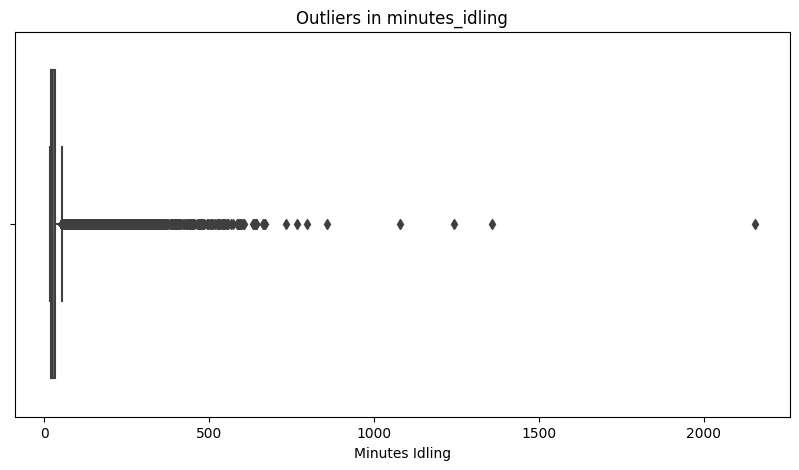

In [0]:
from pyspark.sql.functions import col, count, when
col_name = "minutes_idling"
# IQR 
q1, q3 = data_idle_events.approxQuantile(col_name, [0.25, 0.75], 0.05)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# filter outliers
outliers_df = data_idle_events.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound)).toPandas()

# Plot outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=outliers_df[col_name])
plt.title(f"Outliers in {col_name}")
plt.xlabel("Minutes Idling")
plt.show()

In [0]:
#  unique value counts for categorical columns

print("Unique Value Counts for Categorical Columns:")
for c in categorical_cols:
    unique_count = data_idle_events.select(countDistinct(col(c))).collect()[0][0]
    print(f"{c}: {unique_count} unique values")

Unique Value Counts for Categorical Columns:
start_time: 4602400 unique values
end_time: 4601756 unique values
number: 1073 unique values
status: 2 unique values
make: 77 unique values
model: 328 unique values
group_name: 45 unique values


In [0]:
# the other non-date categorical values are the same as above tables
# get datetype range 
print("DateType Range: ")
datetime_cols = [f.name for f in driving_period.schema.fields if f.dataType.simpleString() == 'timestamp']
if datetime_cols:
    date_ranges = driving_period.select(
        [min(col(c)).alias(f"{c}_min") for c in datetime_cols] +
        [max(col(c)).alias(f"{c}_max") for c in datetime_cols]
    ).collect()[0]

    # prnt the date ranges in the desired format
    for i, col_name in enumerate(datetime_cols):
        min_date = date_ranges[i]
        max_date = date_ranges[i + len(datetime_cols)]
        print(f"{col_name}: ({min_date}, {max_date})")
else:
    print("No datetime columns found.")

DateType Range: 
start_date: (2023-01-01 00:06:43, 2025-02-25 23:59:54)
created_at: (2024-08-09 18:23:42.845445, 2025-02-26 09:00:25.066668)
updated_at: (2024-08-09 18:23:42.845445, 2025-02-26 09:00:25.066668)


**Observation**:
- For `minutes_idling`, there are some outliers values > 1000; typically, the average idling minutes is 8 minutes 
- There are several null `driver_id` that we need to drops

### `accident_register_combined_driverid`


In [0]:
# load the data 
accident_reg_data = spark.read.csv('dbfs:/FileStore/tables/accident_register_combined_driverid.tsv', inferSchema=True, header=True, sep="\t")
accident_reg_data.show()

+------------------------------------------+------------------+-------------------+-------------+--------+--------------------+--------------------------------+--------+------------------+--------------+----+------+----------------+---------------+------------------+-----------------+-----------------+----------------+---------+-------------------+-----+
|Location of Accident (street, city, state)|               DBA|   Date of Accident|Date Reported|Fatality| insured_driver_name|Copy of Sate or Insurance Report|Severity|      Claim Number|Total Incurred|Year|Region|Time of Accident|APMM Recordable|insured_first_name|insured_last_name|driver_first_name|driver_last_name|driver_id|Summary of Accident|Notes|
+------------------------------------------+------------------+-------------------+-------------+--------+--------------------+--------------------------------+--------+------------------+--------------+----+------+----------------+---------------+------------------+-----------------+-

In [0]:
from pyspark.sql.functions import col, count, when
# Show schema
print("Schema:")
accident_reg_data.printSchema()
# Count missing values in each column
print("Missing Values:")
missing_values = accident_reg_data.select([
    count(when(col(c).isNull(), c)).alias(c) for c in accident_reg_data.columns
]).collect()[0]
for col_name, missing_count in zip(accident_reg_data.columns, missing_values):
    print(f"{col_name}: {missing_count}")

Schema:
root
 |-- Location of Accident (street, city, state): string (nullable = true)
 |-- DBA: string (nullable = true)
 |-- Date of Accident: timestamp (nullable = true)
 |-- Date Reported: timestamp (nullable = true)
 |-- Fatality: string (nullable = true)
 |-- insured_driver_name: string (nullable = true)
 |-- Copy of Sate or Insurance Report: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Claim Number: string (nullable = true)
 |-- Total Incurred: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Time of Accident: string (nullable = true)
 |-- APMM Recordable: boolean (nullable = true)
 |-- insured_first_name: string (nullable = true)
 |-- insured_last_name: string (nullable = true)
 |-- driver_first_name: string (nullable = true)
 |-- driver_last_name: string (nullable = true)
 |-- driver_id: integer (nullable = true)
 |-- Summary of Accident: string (nullable = true)
 |-- Notes: string (nullable = tr

In [0]:
# identify numerical and categorical columns
numerical_cols = [f.name for f in accident_reg_data.schema.fields if f.dataType.simpleString() in ['int', 'double', 'float']]
categorical_cols = [f.name for f in accident_reg_data.schema.fields if f.dataType.simpleString() in ['string', 'boolean', 'timestamp']]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['Total Incurred', 'Year', 'driver_id']
Categorical columns: ['Location of Accident (street, city, state)', 'DBA', 'Date of Accident', 'Date Reported', 'Fatality', 'insured_driver_name', 'Copy of Sate or Insurance Report', 'Severity', 'Claim Number', 'Region', 'Time of Accident', 'APMM Recordable', 'insured_first_name', 'insured_last_name', 'driver_first_name', 'driver_last_name', 'Summary of Accident', 'Notes']


In [0]:
# Summary statistics for numerical columns
filtered_numerical_cols = [c for c in numerical_cols if "_id" not in c and c!= "id_x" and c!= "id_y" ]

if filtered_numerical_cols:
    print("Summary Statistics for Numerical Columns:")
    summary_stats = accident_reg_data.select(
        [mean(col(c)).alias(f"{c}_mean") for c in filtered_numerical_cols] +
        [stddev(col(c)).alias(f"{c}_stddev") for c in filtered_numerical_cols] +
        [min(col(c)).alias(f"{c}_min") for c in filtered_numerical_cols] +
        [max(col(c)).alias(f"{c}_max") for c in filtered_numerical_cols]
    )
    summary_stats.show()


Summary Statistics for Numerical Columns:
+-------------------+-----------------+---------------------+------------------+------------------+--------+------------------+--------+
|Total Incurred_mean|        Year_mean|Total Incurred_stddev|       Year_stddev|Total Incurred_min|Year_min|Total Incurred_max|Year_max|
+-------------------+-----------------+---------------------+------------------+------------------+--------+------------------+--------+
| 22746.846153846152|2024.031914893617|    35414.16579761587|0.5551105397049887|               291|    2023|            120000|    2025|
+-------------------+-----------------+---------------------+------------------+------------------+--------+------------------+--------+



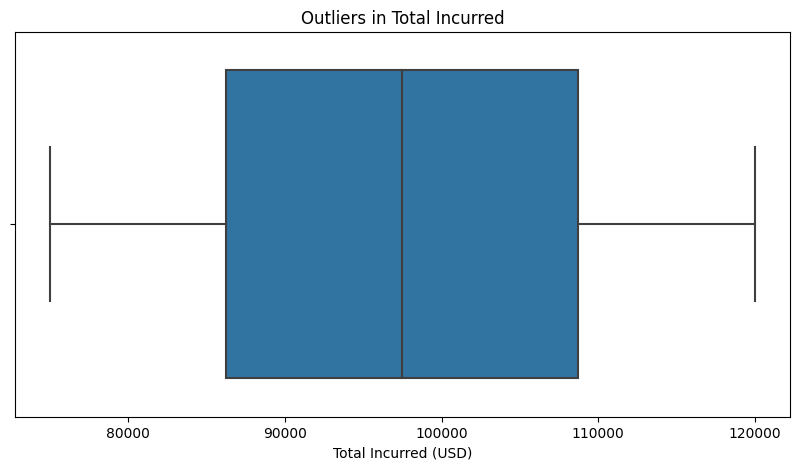

In [0]:
col_name = "Total Incurred"
# IQR 
q1, q3 = accident_reg_data.approxQuantile(col_name, [0.25, 0.75], 0.05)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# filter outliers
outliers_df = accident_reg_data.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound)).toPandas()

# Plot outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=outliers_df[col_name])
plt.title(f"Outliers in {col_name}")
plt.xlabel("Total Incurred (USD)")
plt.show()

In [0]:
# Display unique value counts for categorical columns
print("Unique Value Counts for Categorical Columns:")
for c in categorical_cols:
    unique_count = accident_reg_data.select(countDistinct(col(c))).collect()[0][0]
    print(f"{c}: {unique_count} unique values")

Unique Value Counts for Categorical Columns:
Location of Accident (street, city, state): 292 unique values
DBA: 54 unique values
Date of Accident: 213 unique values
Date Reported: 286 unique values
Fatality: 1 unique values
insured_driver_name: 281 unique values
Copy of Sate or Insurance Report: 1 unique values
Severity: 3 unique values
Claim Number: 71 unique values
Region: 5 unique values
Time of Accident: 35 unique values
APMM Recordable: 2 unique values
insured_first_name: 190 unique values
insured_last_name: 242 unique values
driver_first_name: 179 unique values
driver_last_name: 223 unique values
Summary of Accident: 288 unique values
Notes: 1 unique values


In [0]:
# categorical columns of interest
categorical_columns = ["Severity","Fatality", "Year", "Region"]

#  unique values for each specified categorical column
unique_values_dict = {}

for c in categorical_columns:
    unique_values = accident_reg_data.select(col(c)).distinct().rdd.flatMap(lambda x: x).collect()
    unique_values_dict[c] = unique_values

for col_name, values in unique_values_dict.items():
    print(f"{col_name}: {values}")


Severity: [None, 'SEV1', 'SEV2', 'SEV3']
Fatality: [None, 'No']
Year: [2025, 2023, 2024]
Region: [None, 'Southeast', 'South Central', 'West', 'Gulf South', 'North']


**Observation**:
- There are multiple driver_id that can't be found the the driver database; we would want to eliminate those records
- Missing timestamp and accurate locations on some incidents which might reveal some issue when joining with weather data
- The accident records range from 2021 to 2023
- Some accidents are not related to crashing with other vehicles, some would come from work accident that causes damage to the vehicle 
- The damage cost incurred range from 300 to 120,000 USD 
- `Region` indicates what FusionSite region does this accident happen 

### `monthly_claims_insurance_driverid.csv`

In [0]:
# load the data 
monthly_claim_ins_data = spark.read.csv('dbfs:/FileStore/tables/monthly_claims_insurance_driverid.tsv', inferSchema=True, header=True, sep="\t")
monthly_claim_ins_data.show()

+----+----------+-------------+--------+--------------------+------------------+---------------+--------------------+----------+-------------------+-------------+--------------------+--------------------+------------------------+-------------------+--------------------+----------+------------+----------+------------+------------------+-----------------+-----------------+----------------+---------+
|year| Loss Date|Reported Date|Lag Time|         Client Name|      Claim Number|       Adjuster|       Loss Location|State Code|        Claims Line|   Loss Cause|   Loss Cause Detail|Current Claim Status|Claim Current Close Date|insured_driver_name|    Loss Description|Gross Paid|Loss Reserve|Recoveries|Net Incurred|insured_first_name|insured_last_name|driver_first_name|driver_last_name|driver_id|
+----+----------+-------------+--------+--------------------+------------------+---------------+--------------------+----------+-------------------+-------------+--------------------+---------------

In [0]:
from pyspark.sql.functions import col, count, when
# Show schema
print("Schema:")
monthly_claim_ins_data.printSchema()
# Count missing values in each column
print("Missing Values:")
missing_values = monthly_claim_ins_data.select([
    count(when(col(c).isNull(), c)).alias(c) for c in monthly_claim_ins_data.columns
]).collect()[0]
for col_name, missing_count in zip(monthly_claim_ins_data.columns, missing_values):
    print(f"{col_name}: {missing_count}")

Schema:
root
 |-- year: string (nullable = true)
 |-- Loss Date: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Lag Time: string (nullable = true)
 |-- Client Name: string (nullable = true)
 |-- Claim Number: string (nullable = true)
 |-- Adjuster: string (nullable = true)
 |-- Loss Location: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Claims Line: string (nullable = true)
 |-- Loss Cause: string (nullable = true)
 |-- Loss Cause Detail: string (nullable = true)
 |-- Current Claim Status: string (nullable = true)
 |-- Claim Current Close Date: date (nullable = true)
 |-- insured_driver_name: string (nullable = true)
 |-- Loss Description: string (nullable = true)
 |-- Gross Paid: string (nullable = true)
 |-- Loss Reserve: string (nullable = true)
 |-- Recoveries: string (nullable = true)
 |-- Net Incurred: string (nullable = true)
 |-- insured_first_name: string (nullable = true)
 |-- insured_last_name: string (nullable = true)
 

In [0]:
# identify numerical and categorical columns
numerical_cols = [f.name for f in monthly_claim_ins_data.schema.fields if f.dataType.simpleString() in ['int', 'double', 'float']]
categorical_cols = [f.name for f in monthly_claim_ins_data.schema.fields if f.dataType.simpleString() in ['string', 'boolean', 'timestamp']]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['driver_id']
Categorical columns: ['year', 'Loss Date', 'Reported Date', 'Lag Time', 'Client Name', 'Claim Number', 'Adjuster', 'Loss Location', 'State Code', 'Claims Line', 'Loss Cause', 'Loss Cause Detail', 'Current Claim Status', 'insured_driver_name', 'Loss Description', 'Gross Paid', 'Loss Reserve', 'Recoveries', 'Net Incurred', 'insured_first_name', 'insured_last_name', 'driver_first_name', 'driver_last_name']


## Understanding the categorical and numerical values 


In [0]:
from pyspark.sql.functions import col, regexp_replace

# List of columns to clean
columns_to_clean = ["Gross Paid", "Loss Reserve", "Recoveries", "Net Incurred"]

# Remove "$" and cast to float
for col_name in columns_to_clean:
    monthly_claim_ins_data = monthly_claim_ins_data.withColumn(
        col_name, regexp_replace(col(col_name), r"[\$,]", "").cast("double")
    )

if columns_to_clean:
    print("Summary Statistics for Numerical Columns:")
    summary_stats = monthly_claim_ins_data.select(
        [mean(col(c)).alias(f"{c}_mean") for c in columns_to_clean] +
        [stddev(col(c)).alias(f"{c}_stddev") for c in columns_to_clean] +
        [min(col(c)).alias(f"{c}_min") for c in columns_to_clean] +
        [max(col(c)).alias(f"{c}_max") for c in columns_to_clean]
    )
    summary_stats.show()


Summary Statistics for Numerical Columns:
+------------------+-----------------+------------------+------------------+-----------------+-------------------+-----------------+-------------------+--------------+----------------+--------------+----------------+--------------+----------------+--------------+----------------+
|   Gross Paid_mean|Loss Reserve_mean|   Recoveries_mean| Net Incurred_mean|Gross Paid_stddev|Loss Reserve_stddev|Recoveries_stddev|Net Incurred_stddev|Gross Paid_min|Loss Reserve_min|Recoveries_min|Net Incurred_min|Gross Paid_max|Loss Reserve_max|Recoveries_max|Net Incurred_max|
+------------------+-----------------+------------------+------------------+-----------------+-------------------+-----------------+-------------------+--------------+----------------+--------------+----------------+--------------+----------------+--------------+----------------+
|22661.709401709402|21531.97435897436|-1171.982905982906|45189.094017094016|37568.40797547026|  82193.96790450785|4

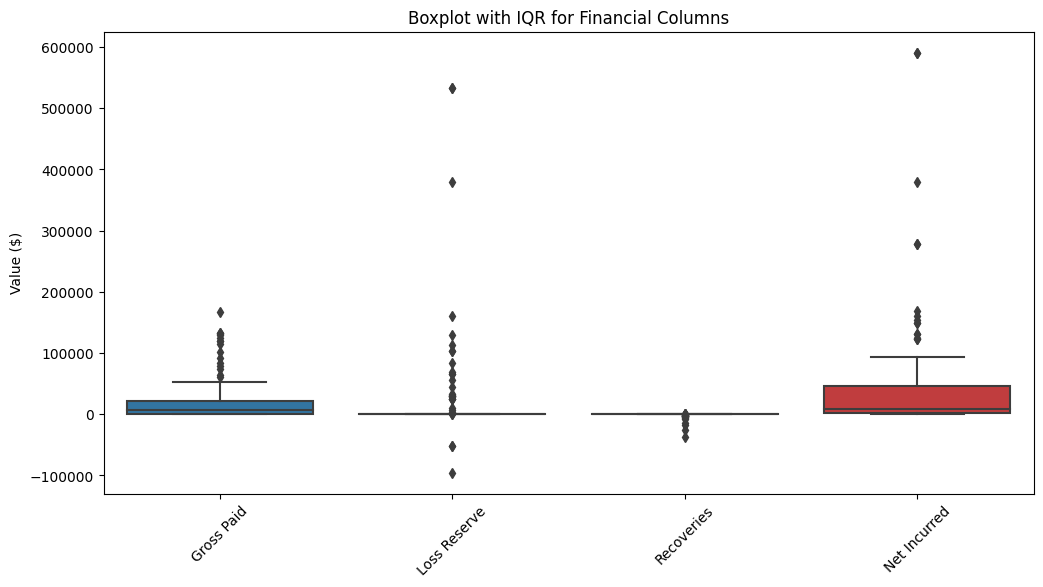

In [0]:
df_pandas = monthly_claim_ins_data.select(columns_to_clean).toPandas()

# Create Boxplots with IQR
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pandas)

# Add labels and title
plt.title("Boxplot with IQR for Financial Columns")
plt.ylabel("Value ($)")
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [0]:
# Display unique value counts for categorical columns
print("Unique Value Counts for Categorical Columns:")
for c in categorical_cols:
    unique_count = monthly_claim_ins_data.select(countDistinct(col(c))).collect()[0][0]
    print(f"{c}: {unique_count} unique values")

Unique Value Counts for Categorical Columns:
year: 4 unique values
Loss Date: 99 unique values
Reported Date: 102 unique values
Lag Time: 46 unique values
Client Name: 2 unique values
Claim Number: 117 unique values
Adjuster: 17 unique values
Loss Location: 112 unique values
State Code: 14 unique values
Claims Line: 5 unique values
Loss Cause: 7 unique values
Loss Cause Detail: 28 unique values
Current Claim Status: 2 unique values
insured_driver_name: 106 unique values
Loss Description: 112 unique values
Gross Paid: 82 unique values
Loss Reserve: 30 unique values
Recoveries: 21 unique values
Net Incurred: 105 unique values
insured_first_name: 87 unique values
insured_last_name: 100 unique values
driver_first_name: 77 unique values
driver_last_name: 87 unique values


In [0]:
# categorical columns of interest
categorical_columns = ["Claims Line","Loss Cause", "Current Claim Status"]

#  unique values for each specified categorical column
unique_values_dict = {}

for c in categorical_columns:
    unique_values = monthly_claim_ins_data.select(col(c)).distinct().rdd.flatMap(lambda x: x).collect()
    unique_values_dict[c] = unique_values

for col_name, values in unique_values_dict.items():
    print(f"{col_name}: {values}")


Claims Line: ['Umbrella', 'Commercial Property', 'General Liability', 'Commercial Auto']
Loss Cause: ['Wind', 'Accident on premises-outside', 'Auto Accident', 'Theft', 'Falling or Flying Object', 'Fire', 'Delivery/Moving/Loading/Unloading']
Current Claim Status: ['Open', 'Closed']


**Observation**
- All the records range from 2023-2025
- Some driver_id is missing due to not being to detect/find driver id from the driver database
- `Gross Paid` has a relatively narrow IQR, meaning most claims have similar payout amounts.
- `Loss Reserve` typically is positive,the negative values indicate adjustments where insurers previously overestimated reserves and later released funds.
- `Loss Reserve` and `Net Incurred` seem to have extremely high values, suggesting that some claims are significantly larger than the majority; or there are some really severed incidents happened


In [0]:
# sc.stop()
# convert to html 
!jupyter nbconvert --to html motive_basic_data.ipynb